# EXPLORATION 06

# 6. 나의 첫 번째 캐글 경진대회, 무작정 따라해보기

* Writier : 송영석
* Date : 2021.10.14

In [2]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir , 'test.csv')


## 1. 데이터 살펴보기
pandas의 read_csv 함수를 사용해 데이터를 읽어오고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [140]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim : {}'.format(data.shape))
print('sub data dim : {}'.format(sub.shape))

train data dim : (15035, 21)
sub data dim : (6468, 20)


In [141]:
y = data['price']


print(data.columns)

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [21]:
train_len = len(data)
data = pd.concat((data, sub), axis=0)

print(len(data))

21503


In [22]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21503 non-null  int64  
 1   date           21503 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       21503 non-null  int64  
 4   bathrooms      21503 non-null  float64
 5   sqft_living    21503 non-null  int64  
 6   sqft_lot       21503 non-null  int64  
 7   floors         21503 non-null  float64
 8   waterfront     21503 non-null  int64  
 9   view           21503 non-null  int64  
 10  condition      21503 non-null  int64  
 11  grade          21503 non-null  int64  
 12  sqft_above     21503 non-null  int64  
 13  sqft_basement  21503 non-null  int64  
 14  yr_built       21503 non-null  int64  
 15  yr_renovated   21503 non-null  int64  
 16  zipcode        21503 non-null  int64  
 17  lat            21503 non-null  float64
 18  long   

## 2. 간단한 전처리 
각 변수들에 대해 결측 유무를 확인하고, 분포를 확인해보면서 간단하게 전처리를 하겠습니다.


### 가격 이상치 정리와 범주화

In [24]:
# max 7,700,000 min 78,000
price_list = data['price'].unique()
Price_list =sorted( price_list)
print(Price_list)

[78000.0, 80000.0, 81000.0, 83000.0, 84000.0, 85000.0, 89000.0, 89950.0, 90000.0, 95000.0, 96500.0, 99000.0, 100000.0, 102500.0, 104950.0, 105000.0, 105500.0, 106000.0, 107000.0, 109000.0, 109500.0, 110000.0, 111300.0, 112000.0, 114000.0, 115000.0, 118000.0, 118125.0, 119500.0, 119900.0, 120000.0, 121800.0, 122000.0, 123000.0, 124000.0, 124500.0, 124740.0, 125000.0, 126000.0, 128000.0, 128750.0, 129000.0, 130000.0, 132500.0, 133000.0, 133400.0, 134000.0, 135000.0, 136500.0, 137124.0, 137900.0, 139000.0, 139500.0, 140000.0, 141800.0, 142000.0, 142500.0, 144000.0, 145000.0, 146000.0, 146300.0, 147200.0, 147400.0, 147500.0, 148000.0, 148900.0, 149900.0, 150000.0, 150550.0, 151000.0, 151600.0, 152000.0, 152500.0, 153000.0, 153503.0, 154000.0, 154200.0, 154500.0, 154950.0, 155000.0, 156000.0, 156601.0, 157340.0, 157500.0, 158000.0, 158800.0, 159000.0, 159075.0, 160000.0, 160797.0, 161000.0, 161700.0, 162000.0, 162500.0, 162950.0, 163000.0, 163250.0, 163500.0, 163800.0, 164000.0, 164808.0, 1

def outlier_iqr(data, column): 

    # lower, upper 글로벌 변수 선언하기     
    global lower, upper    
    
    # 4분위수 기준 지정하기     
    q25, q75 = np.quantile(data[column], 0.25), np.quantile(data[column], 0.75)          
    
    # IQR 계산하기     
    iqr = q75 - q25    
    
    # outlier cutoff 계산하기     
    cut_off = iqr * 1.5          
    
    # lower와 upper bound 값 구하기     
    lower, upper = q25 - cut_off, q75 + cut_off     
    
    print('IQR은',iqr, '이다.')     
    print('lower bound 값은', lower, '이다.')     
    print('upper bound 값은', upper, '이다.')    
    
    # 1사 분위와 4사 분위에 속해있는 데이터 각각 저장하기     
    data1 = data[data[column] > upper]     
    data2 = data[data[column] < lower]    
    
    # 이상치 총 개수 구하기
    return print('총 이상치 개수는', data1.shape[0] + data2.shape[0], '이다.')

outlier_iqr(data,'price')
print("이상치 제거 전 :" , len(data))
data = data[(data['price'] < upper) & (data['price'] > 100000)]
print("이상치 제거 후 :" , len(data))

In [27]:
#가격의 범주화
def price_categorize(price):
    price = (price // 100000)*10
    return price
data['price_cat'] = data.price.apply(price_categorize)
print(len(data['price_cat'].unique()))
print(len(data['price_cat']))

46
21503


In [28]:
data.head(15)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_cat
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,20.0
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,10.0
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,50.0
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,20.0
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,20.0
5,5,20150403T000000,662500.0,3,2.50,3560,9796,1.0,0,0,...,1860,1700,1965,0,98007,47.6007,-122.145,2210,8925,60.0
6,6,20140527T000000,468000.0,2,1.00,1160,6000,1.0,0,0,...,860,300,1942,0,98115,47.6900,-122.292,1330,6000,40.0
7,7,20140528T000000,310000.0,3,1.00,1430,19901,1.5,0,0,...,1430,0,1927,0,98028,47.7558,-122.229,1780,12697,30.0
8,8,20141007T000000,400000.0,3,1.75,1370,9680,1.0,0,0,...,1370,0,1977,0,98074,47.6127,-122.045,1370,10208,40.0
9,9,20150312T000000,530000.0,5,2.00,1810,4850,1.5,0,0,...,1810,0,1900,0,98107,47.6700,-122.394,1360,4850,50.0


### id, date 변수 정리
id 변수는 모델이 집값을 예측하는데 도움을 주지 않으므로 제거합니다.<br>
date 변수는 연월일시간으로 값을 가지고 있는데, 연월만 고려하는 범주형 변수로 만들겠습니다.

In [29]:
sub_id = data['id'][train_len:]
del data['id']

data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str)
data.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_cat
0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,20.0
1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,10.0
2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,50.0
3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,...,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,20.0
4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,...,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,20.0


### 각 변수들의 분포 확인
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

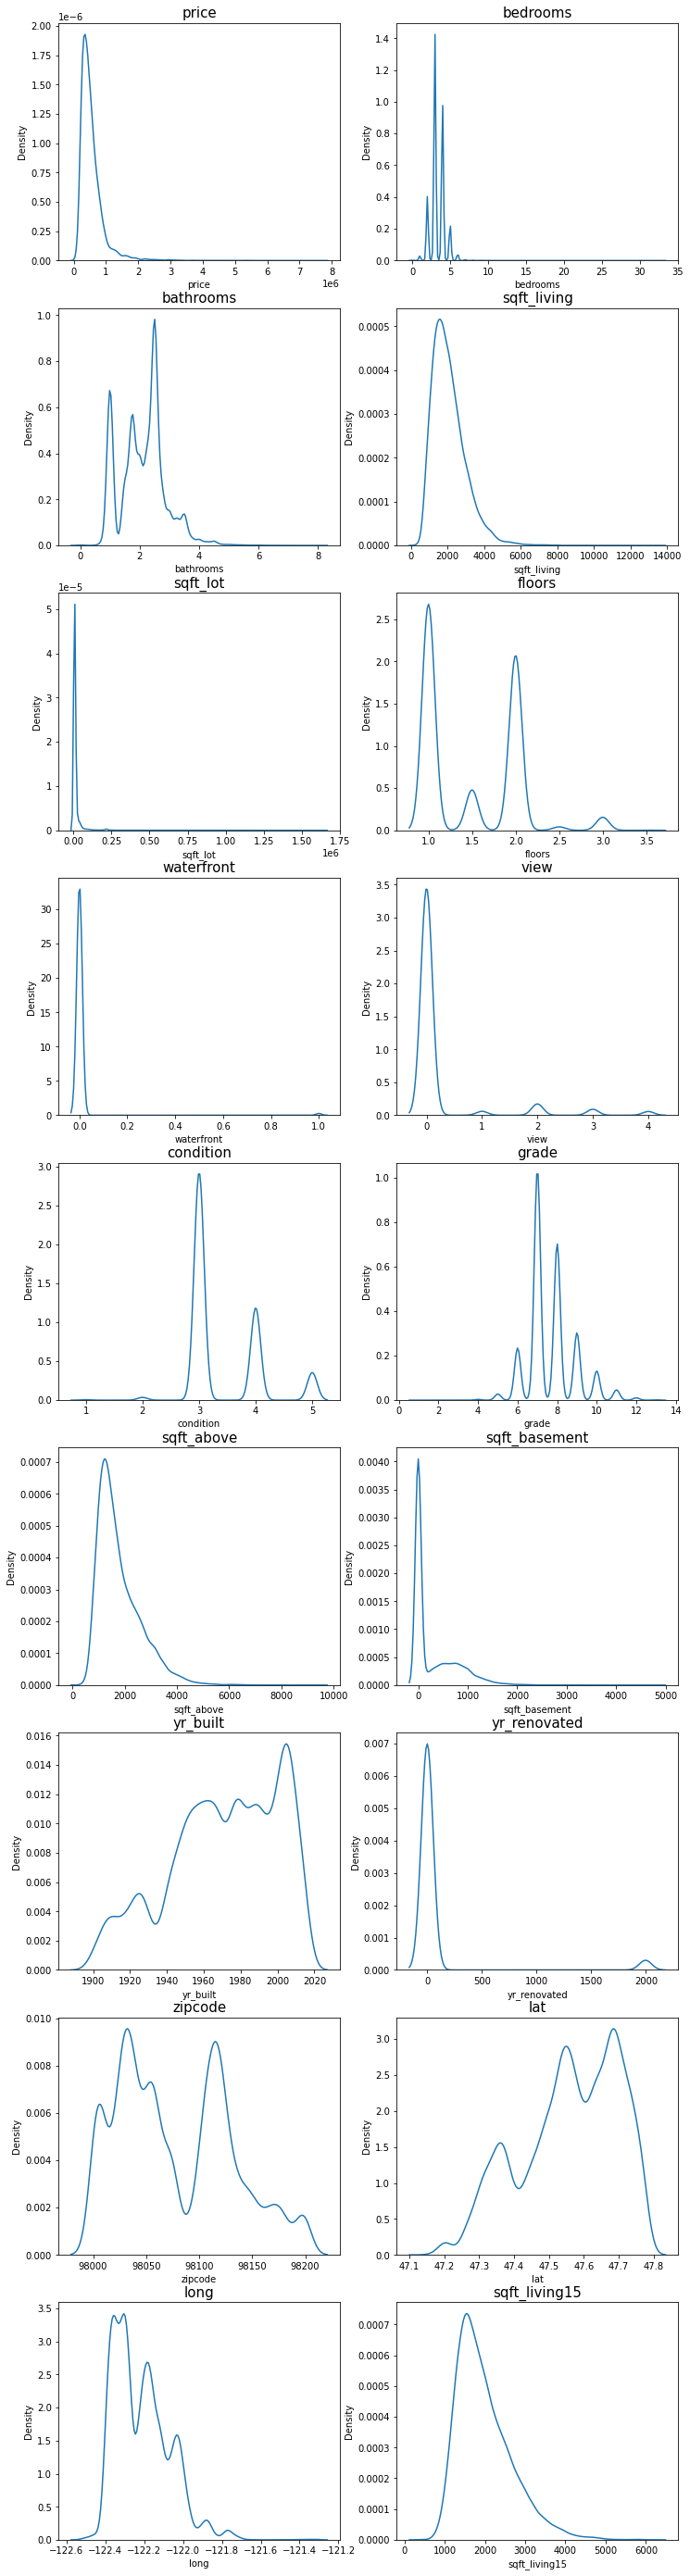

In [30]:
fig, ax = plt.subplots(9, 2, figsize=(12, 50))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

price, bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [31]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

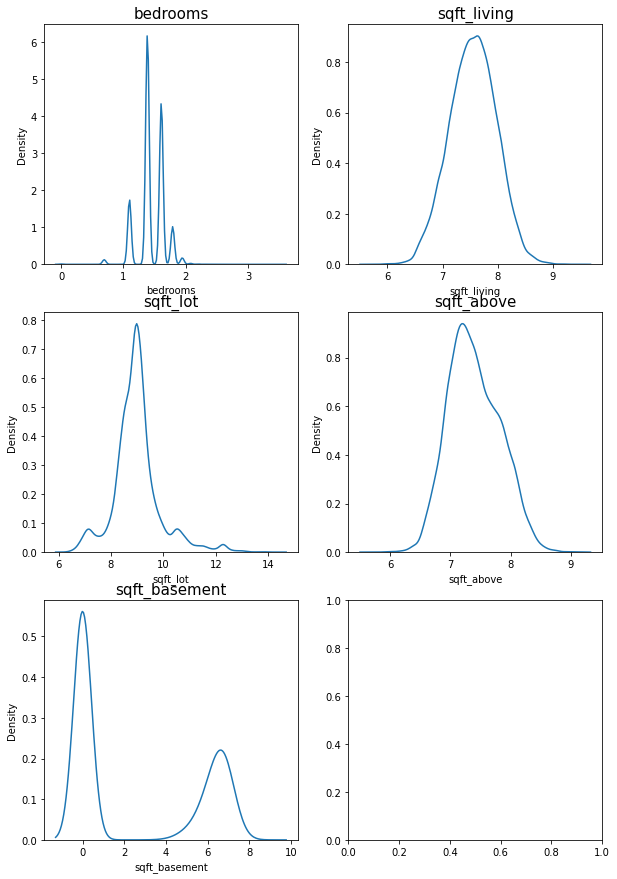

In [32]:
fig, ax = plt.subplots(3, 2, figsize=(10, 15))

count = 0
for row in range(3):
    for col in range(2):
        if count == 5:
            break
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count+=1



In [33]:
# 범주화 features 확인
'''['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'view',
       'condition', 'grade', 'sqft_above', 'sqft_basement', 'zipcode', 'lat',
       'long', 'sqft_living15', 'sqft_lot15', 'price_cat'] '''

print(len(data['condition'].unique()))


5


<AxesSubplot:title={'center':' Correlation of Features'}>

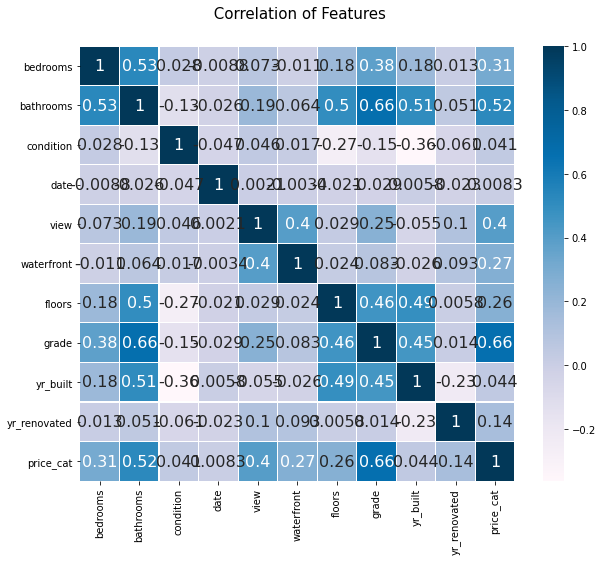

In [34]:
categorical_list = ['bedrooms', 'bathrooms','condition','date','view','waterfront','floors','grade','yr_built','yr_renovated','price_cat']
heatmap_data = data[categorical_list]

colormap = plt.cm.PuBu
plt.figure(figsize=(10, 8))
plt.title(" Correlation of Features", y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths = 0.1, vmax = 1.0,
        square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 16})


In [35]:
#1 이하의 낮은 상관관계를 보인 변수 제거
data.drop(['condition','date','yr_built','yr_renovated'],axis=1)


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,grade,sqft_above,sqft_basement,zipcode,lat,long,sqft_living15,sqft_lot15,price_cat
0,221900.0,1.386294,1.00,7.074117,8.639588,1.0,0,0,7,7.074117,0.000000,98178,47.5112,-122.257,1340,5650,20.0
1,180000.0,1.098612,1.00,6.647688,9.210440,1.0,0,0,6,6.647688,0.000000,98028,47.7379,-122.233,2720,8062,10.0
2,510000.0,1.386294,2.00,7.427144,8.997271,1.0,0,0,8,7.427144,0.000000,98074,47.6168,-122.045,1800,7503,50.0
3,257500.0,1.386294,2.25,7.447751,8.827615,2.0,0,0,7,7.447751,0.000000,98003,47.3097,-122.327,2238,6819,20.0
4,291850.0,1.386294,1.50,6.966967,9.181118,1.0,0,0,7,6.966967,0.000000,98198,47.4095,-122.315,1650,9711,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,NaN,1.386294,1.75,7.313887,9.390075,1.0,0,0,6,7.313887,0.000000,98010,47.3095,-122.002,1320,11303,NaN
6464,NaN,1.386294,2.00,7.307202,7.027315,3.0,0,0,8,7.307202,0.000000,98144,47.5699,-122.288,1400,1230,NaN
6465,NaN,1.386294,2.50,7.178545,7.166266,2.0,0,0,8,7.074117,4.875197,98116,47.5773,-122.409,1330,1265,NaN
6466,NaN,1.098612,0.75,6.928538,7.208600,2.0,0,0,7,6.928538,0.000000,98144,47.5944,-122.299,1020,2007,NaN


In [36]:
data.head(10)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_cat
0,201410,221900.0,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,...,7.074117,0.000000,1955,0,98178,47.5112,-122.257,1340,5650,20.0
1,201502,180000.0,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,...,6.647688,0.000000,1933,0,98028,47.7379,-122.233,2720,8062,10.0
2,201502,510000.0,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,...,7.427144,0.000000,1987,0,98074,47.6168,-122.045,1800,7503,50.0
3,201406,257500.0,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,...,7.447751,0.000000,1995,0,98003,47.3097,-122.327,2238,6819,20.0
4,201501,291850.0,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,...,6.966967,0.000000,1963,0,98198,47.4095,-122.315,1650,9711,20.0
5,201504,662500.0,1.386294,2.50,8.177797,9.189831,1.0,0,0,3,...,7.528869,7.438972,1965,0,98007,47.6007,-122.145,2210,8925,60.0
6,201405,468000.0,1.098612,1.00,7.057037,8.699681,1.0,0,0,4,...,6.758095,5.707110,1942,0,98115,47.6900,-122.292,1330,6000,40.0
7,201405,310000.0,1.386294,1.00,7.266129,9.898576,1.5,0,0,4,...,7.266129,0.000000,1927,0,98028,47.7558,-122.229,1780,12697,30.0
8,201410,400000.0,1.386294,1.75,7.223296,9.177920,1.0,0,0,4,...,7.223296,0.000000,1977,0,98074,47.6127,-122.045,1370,10208,40.0
9,201503,530000.0,1.791759,2.00,7.501634,8.486940,1.5,0,0,3,...,7.501634,0.000000,1900,0,98107,47.6700,-122.394,1360,4850,50.0


### 결측치 확인
먼저 데이터에 결측치가 있는지를 확인하겠습니다.<br>
missingno 라이브러리의 matrix 함수를 사용하면, 데이터의 결측 상태를 시각화를 통해 살펴볼 수 있습니다.

<AxesSubplot:>

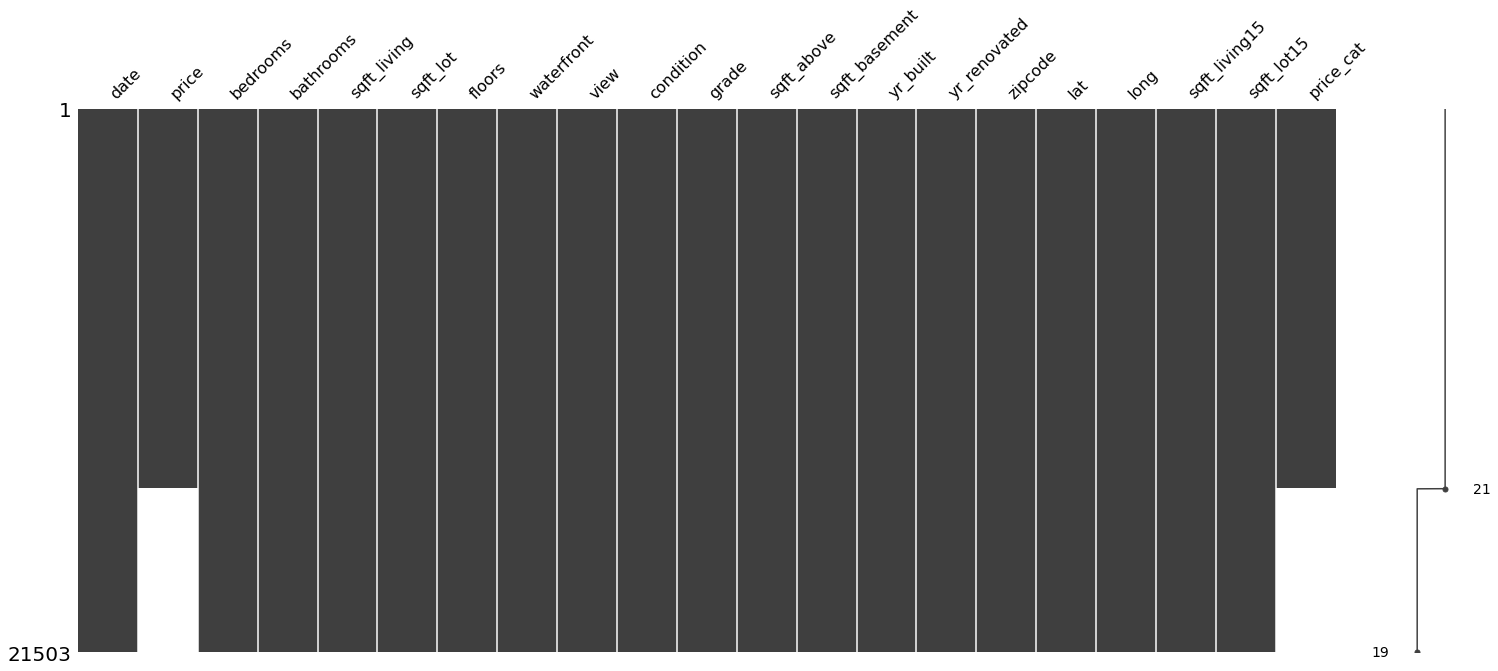

In [37]:
msno.matrix(data)

모든 변수에 결측치가 없는 것으로 보이지만, 혹시 모르니 확실하게 살펴보겠습니다.<br>

In [38]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values)))

date : 0
price : 6468
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0
price_cat : 6468


In [51]:
test = data.iloc[train_len:, :]
x = data.iloc[:train_len, :]
del x['price_cat']
del x['price']

del test['price_cat']
del test['price']
print(test.shape)
test.head(15)

(6468, 19)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201412,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,7.682943,5.993961,1951,1991,98125,47.7210,-122.319,1690,7639
1,201412,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,6.957497,6.814543,1965,0,98136,47.5208,-122.393,1360,5000
2,201405,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,8.266421,7.333676,2001,0,98053,47.6561,-122.005,4760,101930
3,201504,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,6.957497,6.594413,1960,0,98146,47.5123,-122.337,1780,8113
4,201503,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,7.544861,0.000000,2003,0,98038,47.3684,-122.031,2390,7570
5,201407,1.791759,2.50,7.727976,8.748464,2.0,0,0,3,8,7.727976,0.000000,1995,0,98092,47.3266,-122.169,2240,7005
6,201406,1.386294,1.75,7.327123,8.761080,1.0,0,0,3,7,6.673298,6.594413,1948,0,98115,47.6950,-122.304,1520,6235
7,201503,1.609438,2.50,7.852050,8.878219,2.0,0,0,3,8,7.852050,0.000000,2005,0,98052,47.7073,-122.110,2630,6026
8,201412,1.098612,1.50,7.082549,7.143618,3.0,0,0,3,7,7.082549,0.000000,2005,0,98133,47.7274,-122.357,1390,1756
9,201405,1.609438,1.00,7.415175,10.458780,1.0,0,0,1,5,6.836259,6.594413,1933,0,98052,47.6621,-122.132,2160,11467


In [40]:
print(x.shape)
x.head(10)

(15035, 19)


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.000000,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.000000,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.000000,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.000000,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.000000,1963,0,98198,47.4095,-122.315,1650,9711
5,201504,1.386294,2.50,8.177797,9.189831,1.0,0,0,3,8,7.528869,7.438972,1965,0,98007,47.6007,-122.145,2210,8925
6,201405,1.098612,1.00,7.057037,8.699681,1.0,0,0,4,7,6.758095,5.707110,1942,0,98115,47.6900,-122.292,1330,6000
7,201405,1.386294,1.00,7.266129,9.898576,1.5,0,0,4,7,7.266129,0.000000,1927,0,98028,47.7558,-122.229,1780,12697
8,201410,1.386294,1.75,7.223296,9.177920,1.0,0,0,4,7,7.223296,0.000000,1977,0,98074,47.6127,-122.045,1370,10208
9,201503,1.791759,2.00,7.501634,8.486940,1.5,0,0,3,7,7.501634,0.000000,1900,0,98107,47.6700,-122.394,1360,4850


## 3. 모델링
### Average Blending
여러가지 모델의 결과를 산술 평균을 통해 Blending 모델을 만들겠습니다.

In [41]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

### Cross Validation
교차 검증을 통해 모델의 성능을 간단히 평가하겠습니다.

In [42]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [43]:
get_cv_score(models)

Model GradientBoosting CV score : 0.8597
Model XGBoost CV score : 0.8861
Model LightGBM CV score : 0.8819


### Make Submission

회귀 모델의 경우에는 cross_val_score 함수가 R<sup>2</sup>를 반환합니다.<br>
R<sup>2</sup> 값이 1에 가까울수록 모델이 데이터를 잘 표현함을 나타냅니다. 3개 트리 모델이 상당히 훈련 데이터에 대해 괜찮은 성능을 보여주고 있습니다.<br> 훈련 데이터셋으로 3개 모델을 학습시키고, Average Blending을 통해 제출 결과를 만들겠습니다.

In [44]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [45]:
y_pred = AveragingBlending(models, x, y, sub)

In [46]:
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub.head()

,id,price
0,15035,5.299667e+05
1,15036,4.307262e+05
2,15037,1.361677e+06
3,15038,3.338036e+05
4,15039,3.089006e+05


In [47]:
sub.to_csv('submission.csv', index=False)

In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  object 
 1   price          15035 non-null  float64
 2   bedrooms       21503 non-null  float64
 3   bathrooms      21503 non-null  float64
 4   sqft_living    21503 non-null  float64
 5   sqft_lot       21503 non-null  float64
 6   floors         21503 non-null  float64
 7   waterfront     21503 non-null  int64  
 8   view           21503 non-null  int64  
 9   condition      21503 non-null  int64  
 10  grade          21503 non-null  int64  
 11  sqft_above     21503 non-null  float64
 12  sqft_basement  21503 non-null  float64
 13  yr_built       21503 non-null  int64  
 14  yr_renovated   21503 non-null  int64  
 15  zipcode        21503 non-null  int64  
 16  lat            21503 non-null  float64
 17  long           21503 non-null  float64
 18  sqft_li

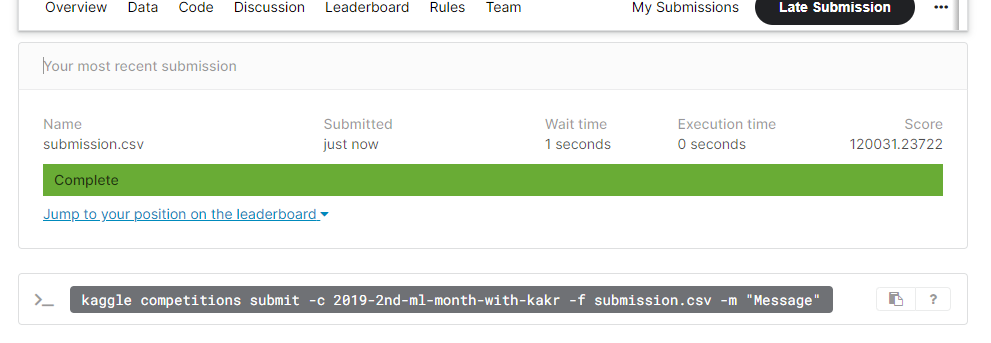

In [4]:
import os
from IPython.display import Image
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/12.PNG'
Image(data_dir) 

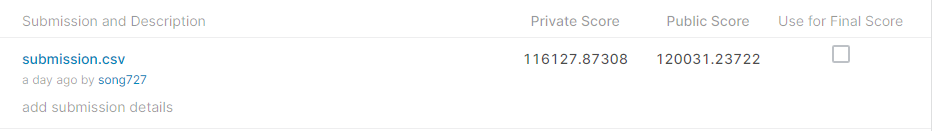

In [5]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/12_1.PNG'
Image(data_dir) 

### 120031점이 나와서 개선이 필요

In [59]:
x['date'] = x['date'].apply(lambda i: i[:6]).astype(int)
x.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711


In [52]:
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)
test.shape


(6468, 19)

In [53]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [60]:

print(x.columns)
x.head(5)
x.shape
x.isnull().sum()

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
#random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020        # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


In [56]:
gboost.__class__.__name__

'GradientBoostingRegressor'

In [142]:
y.shape
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [61]:
df = {}

for model in models:
    # 모델 이름 획득
    model_name = model.__class__.__name__

    # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
    X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=random_state, test_size=0.2)

    # 모델 학습
    model.fit(X_train, y_train)
    
    # 예측
    y_pred = model.predict(X_test)

    # 예측 결과의 rmse값 저장
    df[model_name] = rmse(y_test, y_pred)
    
    # data frame에 저장
    score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
df

{'GradientBoostingRegressor': 128360.17376623847,
 'XGBRegressor': 110319.30179305901,
 'LGBMRegressor': 111906.9477184206,
 'RandomForestRegressor': 125325.08375075871}

In [62]:
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

In [63]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
            
    return score_df

하이퍼 파라미터 튜닝의 최강자, 그리드 탐색

In [64]:
x.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,1650,9711


In [205]:
#model, param_grid와 함께 다른 여러 가지 인자를 넣어서 GridSearchCV를 수행
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [700,800],
    'max_depth': [3,4],
    'learning_rate' : [ 0.06,0.07,0.08]
   
}
model = LGBMRegressor(random_state=random_state)
grid_model = GridSearchCV(model, param_grid=param_grid, \
                        scoring='neg_mean_squared_error', \
                        cv=5, verbose=1, n_jobs=5)

grid_model.fit(x, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   24.5s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   35.8s finished


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'learning_rate': [0.06, 0.07, 0.08],
                         'max_depth': [3, 4], 'n_estimators': [700, 800]},
             scoring='neg_mean_squared_error', verbose=1)

In [206]:
#4가지 조합 실험에 대한 결과
grid_model.cv_results_

{'mean_fit_time': array([2.13669577, 2.39303775, 2.61110067, 3.5083539 , 2.12512832,
        2.28659992, 2.63136349, 3.14317546, 2.38058295, 2.61944714,
        2.61659856, 2.49828997]),
 'std_fit_time': array([0.44931671, 0.45553754, 0.31007031, 0.68572417, 0.44368275,
        0.36059757, 0.37798115, 0.44776351, 0.47360943, 0.52860257,
        0.59860231, 0.65196015]),
 'mean_score_time': array([0.29767575, 0.33509998, 0.33298955, 0.38350148, 0.32251034,
        0.29714351, 0.35046659, 0.32046213, 0.30368509, 0.26337752,
        0.37550778, 0.25564489]),
 'std_score_time': array([0.07320874, 0.09710402, 0.08675421, 0.11317428, 0.12127213,
        0.07617777, 0.11832483, 0.01542092, 0.08828983, 0.00941289,
        0.07395596, 0.06386256]),
 'param_learning_rate': masked_array(data=[0.06, 0.06, 0.06, 0.06, 0.07, 0.07, 0.07, 0.07, 0.08,
                    0.08, 0.08, 0.08],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, Fals

In [207]:
#어떤 파라미터 조합일 때 점수가 어떻게 나오게 되는지에 관한 것이겠죠.
#파라미터 조합은 위 딕셔너리 중 params에, 각각에 대한 테스트 점수는 mean_test_score에 저장
params = grid_model.cv_results_['params']
params

[{'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 700},
 {'learning_rate': 0.06, 'max_depth': 3, 'n_estimators': 800},
 {'learning_rate': 0.06, 'max_depth': 4, 'n_estimators': 700},
 {'learning_rate': 0.06, 'max_depth': 4, 'n_estimators': 800},
 {'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 700},
 {'learning_rate': 0.07, 'max_depth': 3, 'n_estimators': 800},
 {'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 700},
 {'learning_rate': 0.07, 'max_depth': 4, 'n_estimators': 800},
 {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 700},
 {'learning_rate': 0.08, 'max_depth': 3, 'n_estimators': 800},
 {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 700},
 {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 800}]

In [208]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02737452, -0.0270702 , -0.02635655, -0.02625208, -0.02698138,
       -0.0267288 , -0.02620837, -0.02609538, -0.02672979, -0.02652052,
       -0.02617786, -0.02613215])

In [209]:
results = pd.DataFrame(params)
results['score'] = score

results

,learning_rate,max_depth,n_estimators,score
0,0.06,3,700,-0.027375
1,0.06,3,800,-0.027070
2,0.06,4,700,-0.026357
3,0.06,4,800,-0.026252
4,0.07,3,700,-0.026981
5,0.07,3,800,-0.026729
6,0.07,4,700,-0.026208
7,0.07,4,800,-0.026095
8,0.08,3,700,-0.026730
9,0.08,3,800,-0.026521


In [210]:

results['RMSE'] = np.sqrt(-1 * results['score'])

results


,learning_rate,max_depth,n_estimators,score,RMSE
0,0.06,3,700,-0.027375,0.165452
1,0.06,3,800,-0.027070,0.164530
2,0.06,4,700,-0.026357,0.162347
3,0.06,4,800,-0.026252,0.162025
4,0.07,3,700,-0.026981,0.164260
5,0.07,3,800,-0.026729,0.163489
6,0.07,4,700,-0.026208,0.161890
7,0.07,4,800,-0.026095,0.161541
8,0.08,3,700,-0.026730,0.163492
9,0.08,3,800,-0.026521,0.162851


In [211]:
#컬럼의 이름을 RMSLE로 변환
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.06,3,700,-0.027375,0.165452
1,0.06,3,800,-0.027070,0.164530
2,0.06,4,700,-0.026357,0.162347
3,0.06,4,800,-0.026252,0.162025
4,0.07,3,700,-0.026981,0.164260
5,0.07,3,800,-0.026729,0.163489
6,0.07,4,700,-0.026208,0.161890
7,0.07,4,800,-0.026095,0.161541
8,0.08,3,700,-0.026730,0.163492
9,0.08,3,800,-0.026521,0.162851


In [212]:
# 위의 표를 `RMSLE`가 낮은 순서대로 정렬해주세요.
results = results.sort_values('RMSLE')
results

,learning_rate,max_depth,n_estimators,score,RMSLE
7,0.07,4,800,-0.026095,0.161541
11,0.08,4,800,-0.026132,0.161654
10,0.08,4,700,-0.026178,0.161796
6,0.07,4,700,-0.026208,0.161890
3,0.06,4,800,-0.026252,0.162025
2,0.06,4,700,-0.026357,0.162347
9,0.08,3,800,-0.026521,0.162851
5,0.07,3,800,-0.026729,0.163489
8,0.08,3,700,-0.026730,0.163492
4,0.07,3,700,-0.026981,0.164260


가장 좋은 조합은 learning_rate = 0.07, max_depth=4, n_estimators=800 이군요.  
해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출해보겠습니다.

In [213]:
model = LGBMRegressor(learning_rate = 0.07 ,max_depth=4, n_estimators=800, random_state=random_state)
model.fit(x, y)

prediction = model.predict(test)
prediction

array([13.16158442, 13.09188412, 14.13501829, ..., 13.08472044,
       12.66587851, 13.0500622 ])

In [214]:
#np.expm1()을 씌워서 다시 원래 스케일로 되돌리는 것
prediction = np.expm1(prediction)
prediction

array([ 519999.17354004,  484989.27683464, 1376449.0206721 , ...,
        481527.37551545,  316752.29757262,  465124.34227918])

In [215]:
#sample_submission.csv 파일을 가져오기
data_dir = os.getenv('HOME')+'/aiffel/Ex01'

submission_path = join(data_dir, 'submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,5.141831e+05
1,15036,4.507192e+05
2,15037,1.305007e+06
3,15038,2.989040e+05
4,15039,3.274280e+05


In [216]:
submission['price'] = prediction
submission.head()
len(submission)

6468

In [218]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '11')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/Ex01/submission_lgbm_RMSLE_11.csv


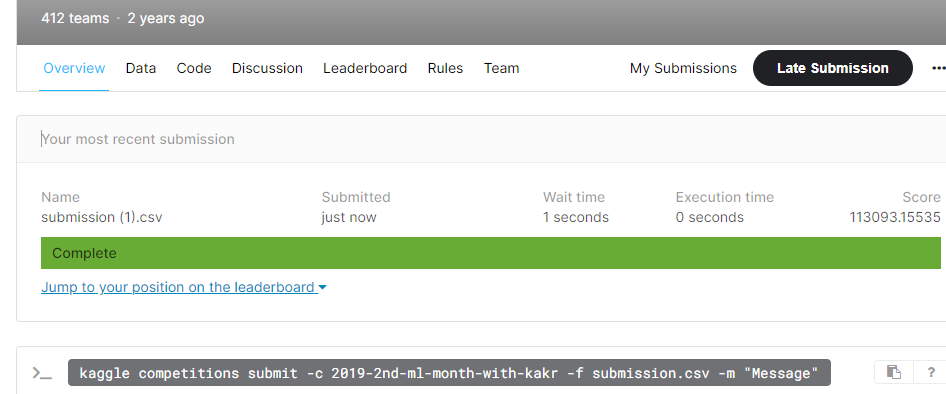

In [10]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/11.PNG'
Image(data_dir)

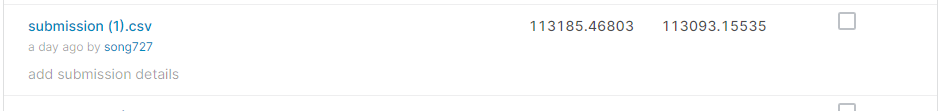

In [6]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/11_1.PNG'
Image(data_dir) 

### 아직도...110000이 안되네요 blending 하겠습니다

XGboost를 이용

xgboost 직접 parameter 바꿔가며 score 확인

In [240]:
model = XGBRegressor(learning_rate =0.1,max_depth=5, n_estimators=1000, random_state=random_state)
model.fit(x, y)
prediction = model.predict(test)
prediction

array([13.18173 , 13.05544 , 14.198373, ..., 13.073201, 12.708563,
       13.019158], dtype=float32)

In [241]:
#np.expm1()을 씌워서 다시 원래 스케일로 되돌리는 것
prediction = np.expm1(prediction)
prediction

array([ 530581.25,  467632.4 , 1466475.  , ...,  476012.34,  330565.4 ,
        450970.03], dtype=float32)

In [242]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    print("Model {} CV score : {:.4f}".format('xgboost', np.mean(cross_val_score(models, x.values, y)),kf=kfold))

In [243]:
get_cv_score(model)

Model xgboost CV score : 0.9048


### xgboost와 lgbmRegressor를 blending 하여 결과를 만들겠습니다.

In [244]:
xgboost = xgb.XGBRegressor(learning_rate =0.1,max_depth=5, n_estimators=1000, random_state=random_state)
lightgbm = lgb. LGBMRegressor(learning_rate = 0.07 ,max_depth=4, n_estimators=800, random_state=random_state)

models = [{'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [245]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [246]:
y_pred = AveragingBlending(models, x, y, test)

In [247]:
y_pred = np.expm1(y_pred)
sub = pd.DataFrame(data={'id':sub_id,'price':y_pred})
sub.head()

,id,price
0,15035,5.252636e+05
1,15036,4.762318e+05
2,15037,1.420749e+06
3,15038,3.064473e+05
4,15039,3.259867e+05


In [248]:
sub.to_csv('submission.csv', index=False)

In [249]:
def get_cv_score(models):
    kfold = KFold(n_splits=5, random_state=2019).get_n_splits(x.values)
    for m in models:
        print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], x.values, y)), 
                                             kf=kfold))

In [250]:
get_cv_score(models)

Model XGBoost CV score : 0.9048
Model LightGBM CV score : 0.9060


## 많은 시도 끝에 110000아래의 점수를 획득하였습니다.

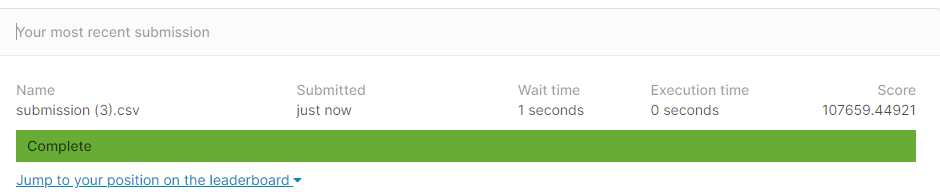

In [9]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/10.PNG'
Image(data_dir)

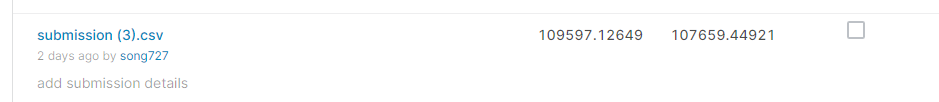

In [7]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/10_1.PNG'
Image(data_dir) 

# 회고

### 1. 데이터 전처리를 변수마다 boxplot을 하고 싶었지만 features와 price의 관계를 보는데에 집중했습니다. domain 지식이 부족하여 함부로 이상치를 제거하기보다 관련 변수를 얻는 것에 집중하였습니다.
### 2. heatmap을 통해 categorical feature들의 price와의 관계를 보고 0.1이하의 관련이 된것들을 삭제하며 정확도를 높이고자 하였습니다. 
### 3. 다른 전처리를 더 알아보며 하지 못한 것이 아쉬운 것 같습니다.
### 4. LgbmRegressor의 parameter 설정에도 시간을 많이 쏟았습니다. 중간에 2^max depth가 branch = 31 보다 커지면 안된다는 것을 뒤늦게 확인하고 다시 수정하였습니다.
### 5. Lgbm으로도 전처리를 더 잘하면 점수를 높일 수 있을거 같았지만 애증의 Xgboost를 써보기로 하였습니다.
### 6. Xgboost의 gridsearch가 시간이 너무 오래걸려 직접 parameter를 수정하고 validation score를 확인하는 식으로 점수를 높이고자 하였습니다.
### 7. 최적의 xgboost를 찾은 뒤에는 더욱 점수를 높이고자 blending을 하여 110000아래의 점수를 달성하였습니다.